In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
TARGET_COL = "coarse_genre_top"
OTHERS = ["genre_top"]
TEST_SIZE = 0.2
N_SPLITS = 5

## Load datasets

In [ ]:
df_train = pd.read_csv("../DataBase/processed/train_data.csv")
print(df_train.shape)

df_test = pd.read_csv("../DataBase/processed/test_data.csv")
print(df_test.shape)

(99995, 34)


## Data preprocessing

In [ ]:
df_train = df_train[df_train[TARGET_COL].notna()].dropna().copy()
print(df_train.shape)

df_test = df_test[df_test[TARGET_COL].notna()].dropna().copy()
print(df_test.shape)

(6867, 34)


In [ ]:
label_encoder = LabelEncoder()
df_train[TARGET_COL] = label_encoder.fit_transform(df_train[TARGET_COL])
df_test[TARGET_COL] = label_encoder.transform(df_test[TARGET_COL])

mapping = dict(zip(label_encoder.classes_, np.arange(len(label_encoder.classes_))))
print(mapping)

{'Acoustic': np.int64(0), 'Energique': np.int64(1), 'Rock': np.int64(2), 'Traditionnal': np.int64(3)}


In [ ]:
X_train, X_test = df_train.drop(columns=[TARGET_COL] + OTHERS), df_test.drop(columns=[TARGET_COL]+OTHERS)
y_train, y_test = df_train[TARGET_COL], df_test[TARGET_COL]

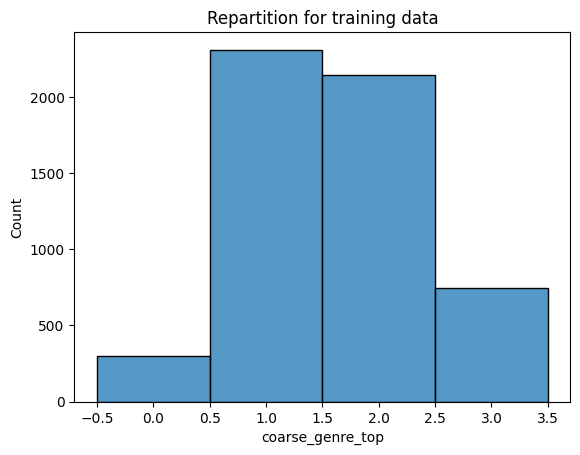

In [ ]:
ax = sns.histplot(y_train, discrete=True)
ax.set_title("Repartition for training data")
plt.show()

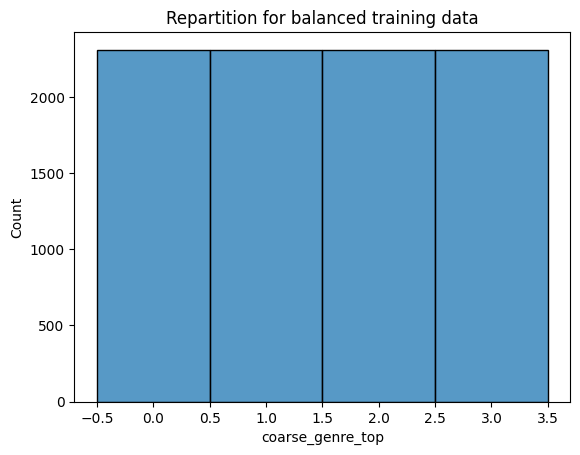

In [ ]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

ax = sns.histplot(y_train_balanced, discrete=True)
ax.set_title("Repartition for balanced training data")
plt.show()

## Model training

In [ ]:
k_fold = KFold(N_SPLITS)

### Logistic regression

#### Training with basic hyperparams

In [ ]:
logistic_regression = LogisticRegression(random_state=42)

scores = cross_validate(logistic_regression, X_train, y_train, cv=k_fold)["test_score"]
print("Accuracy:", round(np.mean(scores), 3), "+-", round(np.std(scores), 3))

c:\Users\Lesli\Documents\Cours\IMT\3A\Fondamentals of Machine Learning\Supervised_Challenge\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Lesli\Documents\Cours\IMT\3A\Fondamentals of Machine Learning\Supervised_Challenge\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergenc

Accuracy: (np.float64(0.643), '+-', np.float64(0.011))


c:\Users\Lesli\Documents\Cours\IMT\3A\Fondamentals of Machine Learning\Supervised_Challenge\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
logistic_regression.fit(X_train_balanced, y_train_balanced)
predictions = logistic_regression.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
accuracy_logistic_regression = report_dict['accuracy']

              precision    recall  f1-score   support

           0       0.23      0.60      0.33        88
           1       0.74      0.61      0.67       585
           2       0.65      0.54      0.59       513
           3       0.42      0.53      0.47       188

    accuracy                           0.57      1374
   macro avg       0.51      0.57      0.52      1374
weighted avg       0.63      0.57      0.59      1374



c:\Users\Lesli\Documents\Cours\IMT\3A\Fondamentals of Machine Learning\Supervised_Challenge\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Training with hyperparams optimization

In [ ]:
PARAM_GRID = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

In [ ]:
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=PARAM_GRID,
    cv= KFold(n_splits=N_SPLITS),
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_balanced, y_train_balanced)

In [ ]:
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score (based on training data): {grid_search.best_score_:.4f}")
predictions = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
accuracy_logistic_regression_optimization = report_dict['accuracy']

### KNN

#### Training with basic hyperparams

In [ ]:
knn = KNeighborsClassifier()

scores = cross_validate(knn, X_train, y_train, cv=k_fold)["test_score"]
print("Accuracy:", round(np.mean(scores), 3), "+-", round(np.std(scores), 3))

Accuracy: 0.704 +- 0.012


In [ ]:
knn.fit(X_train_balanced, y_train_balanced)
predictions = knn.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
accuracy_knn = report_dict['accuracy']

              precision    recall  f1-score   support

           0       0.37      0.76      0.50        88
           1       0.79      0.66      0.72       585
           2       0.75      0.65      0.70       513
           3       0.53      0.73      0.61       188

    accuracy                           0.67      1374
   macro avg       0.61      0.70      0.63      1374
weighted avg       0.71      0.67      0.68      1374



#### Training with hyperparams

In [ ]:
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(random_state=42),
    param_grid=PARAM_GRID,
    cv= KFold(n_splits=N_SPLITS),
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_balanced, y_train_balanced)

In [ ]:
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score (based on training data): {grid_search.best_score_:.4f}")
predictions = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
accuracy_knn_optimization = report_dict['accuracy']

### SVC

#### Traiining with basic hyperparams

In [ ]:
svc = SVC(random_state=42)

scores = cross_validate(svc, X_train, y_train, cv=k_fold)["test_score"]
print("Accuracy:", round(np.mean(scores), 3), "+-", round(np.std(scores), 3))

Accuracy: 0.57 +- 0.016


In [ ]:
svc.fit(X_train_balanced, y_train_balanced)
predictions = svc.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
accuracy_svc = report_dict['accuracy']

#### Training with hyperparams optimization

In [ ]:
PARAM_GRID = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 0.1]
}

In [ ]:
grid_search = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=PARAM_GRID,
    cv= KFold(n_splits=N_SPLITS),
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_balanced, y_train_balanced)

In [ ]:
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score (based on training data): {grid_search.best_score_:.4f}")
predictions = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
accuracy_svc_optimization = report_dict['accuracy']

### Random Forest

#### Training with basic hyperparams

In [ ]:
# with spectral and echonest features
random_forest = RandomForestClassifier(random_state=42)

scores = cross_validate(random_forest, X_train, y_train, cv=k_fold)["test_score"]
print("Accuracy:", round(np.mean(scores), 3), "+-", round(np.std(scores), 3))

Accuracy: 0.772 +- 0.011


In [ ]:
random_forest.fit(X_train_balanced, y_train_balanced)
predictions = random_forest.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
accuracy_random_forest = report_dict['accuracy']

              precision    recall  f1-score   support

           0       0.58      0.72      0.64        88
           1       0.80      0.79      0.80       585
           2       0.78      0.71      0.74       513
           3       0.64      0.72      0.68       188

    accuracy                           0.75      1374
   macro avg       0.70      0.74      0.71      1374
weighted avg       0.75      0.75      0.75      1374



#### Training with hyperparams optimization

In [ ]:
PARAM_GRID = {
    "n_estimators": [100, 300, 500],
    "max_depth": [10, 20, None], # None permet aux arbres de se développer pleinement
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

In [ ]:
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=PARAM_GRID,
    cv= KFold(n_splits=N_SPLITS),
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   5.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   6.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   6.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   6.1s
[CV] END max_depth=10, min_sa

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [10, 20, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 300, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,KFold(n_split...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [ ]:
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score (based on training data): {grid_search.best_score_:.4f}")
predictions = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
accuracy_random_forest_optimization = report_dict['accuracy']

Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV score (based on training data): 0.8048
              precision    recall  f1-score   support

           0       0.61      0.70      0.66        88
           1       0.81      0.80      0.80       585
           2       0.78      0.72      0.75       513
           3       0.64      0.75      0.69       188

    accuracy                           0.76      1374
   macro avg       0.71      0.74      0.72      1374
weighted avg       0.76      0.76      0.76      1374



### XGBoost

#### Training with basic hyperparams

In [ ]:
# with spectral and echonest features
xgb = XGBClassifier(random_state=42)

scores = cross_validate(xgb, X_train, y_train, cv=k_fold)["test_score"]
print("Accuracy:", round(np.mean(scores), 3), "+-", round(np.std(scores), 3))

Accuracy: 0.823 +- 0.008


In [ ]:
xgb.fit(X_train_balanced, y_train_balanced)
predictions = xgb.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
accuracy_xgb = report_dict['accuracy']
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81        88
           1       0.84      0.84      0.84       585
           2       0.81      0.79      0.80       513
           3       0.72      0.77      0.74       188

    accuracy                           0.81      1374
   macro avg       0.79      0.80      0.80      1374
weighted avg       0.81      0.81      0.81      1374

[[ 72   3   9   4]
 [  4 491  67  23]
 [  8  72 403  30]
 [  5  17  21 145]]


#### Training with hyperparams optimization

In [ ]:
PARAM_GRID = {
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 5],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [500, 1000],
}

In [ ]:
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=PARAM_GRID,
    cv= KFold(n_splits=N_SPLITS),
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   2.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   2.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total

/Users/antoinekerboul/Documents/IMT_Atlantique/4A/FML/Challenges/supervised-challenge/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, subsample=0.7; total time=  24.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, subsample=0.7; total time=  24.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, subsample=0.9; total time=  24.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, subsample=0.9; total time=  24.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, subsample=0.9; total time=  24.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, subsample=0.9; total time=  24.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, subsample=0.9; total time=  24.8s
[CV] END colsample_bytree=0.7, learning_r

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.7, 0.9], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, ...], 'min_child_weight': [1, 5], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,KFold(n_split...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softprob'


In [ ]:
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score (based on training data): {grid_search.best_score_:.4f}")
predictions = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
accuracy_xgb_optimization = report_dict['accuracy']

Best params: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.7}
Best CV score (based on training data): 0.8817
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        88
           1       0.84      0.84      0.84       585
           2       0.82      0.81      0.81       513
           3       0.78      0.78      0.78       188

    accuracy                           0.82      1374
   macro avg       0.80      0.82      0.81      1374
weighted avg       0.82      0.82      0.82      1374



## Comparaison

In [ ]:
models = ['Logistic Reg', 'KNN', 'SVC', 'Random Forest', 'XGBoost']

accuracies = [
    accuracy_logistic_regression, accuracy_knn, accuracy_svc, accuracy_random_forest, accuracy_xgb,
    accuracy_logistic_regression_optimization, accuracy_knn_optimization, accuracy_svc_optimization, 
    accuracy_random_forest_optimization, accuracy_xgb_optimization
]

config = ['Standard', 'Standard','Standard','Standard','Standard', 
                'Optimization', 'Optimization', 'Optimization', 'Optimization', 'Optimization']

results = {
    'Modèle': models,
    'Accuracy': accuracies,
    'Configuration': config
}

df_comparaison = pd.DataFrame(results)

print(df_comparaison)

In [ ]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 7))

# Créer le Bar Plot groupé :
# x: La variable catégorielle principale (Modèle)
# y: La variable numérique (Accuracy)
# hue: La variable pour la légende et les groupements (Configuration)
bar_plot = sns.barplot(
    x='Modèle', 
    y='Accuracy', 
    hue='Configuration', 
    data=df_comparaison, 
    palette='Set1' # Un jeu de couleurs distinct
)

# Ajouter des étiquettes et un titre
plt.title('Comparaison de l\'Accuracy des Modèles (Standard vs. Optimisé)')
plt.ylabel('Accuracy Moyenne')
plt.xlabel('Modèle de Classification')

# Facultatif : Positionner la légende (elle est créée automatiquement par 'hue')
plt.legend(title='Configuration du Modèle', loc='upper right')

# Facultatif : Ajouter les valeurs numériques au-dessus des barres (plus complexe pour les barres groupées, mais voici le principe)
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.3f')

plt.show()